In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from molvecgen.vectorizers import SmilesVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas, numpy, random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# To simply model, we setup a baseline, when molecular's mu > baseline, we set it to 1, otherwise 0
baseline = 2.5

In [3]:
# dataset
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        mols = self.molecules[idx]
         
        #The vectorizer was written to work with batches, 
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = float(self.y[idx] > baseline)
        #print("self.y[idx]", self.y[idx], 'label', label)

        target = torch.FloatTensor([label])
        
        return sample, label, target

,smiles,mu,alpha,homo,lumo,gap,r2,zpve,cv,u0,u298,h298,g298,Molecule
350,C#CC(=O)CO,4.1336,46.43,-0.2661,-0.0573,0.2088,617.4214,0.070046,22.333,-305.130313,-305.123605,-305.122661,-305.160728,
351,C(C(=O)C#N)O,4.1197,41.54,-0.3004,-0.0881,0.2122,596.5667,0.059291,20.617,-321.230055,-321.223616,-321.222672,-321.260329,
352,CCC(=O)C=O,1.0401,47.28,-0.2515,-0.0944,0.1571,641.1289,0.093575,22.634,-306.392828,-306.385878,-306.384934,-306.424157,

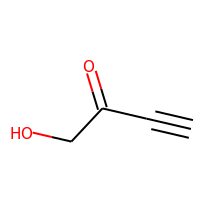
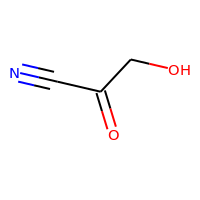
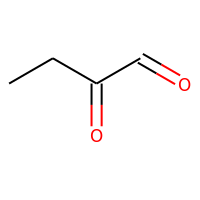

In [4]:
# whole data
dataset = pandas.read_csv('dataset/qm9.csv')

# Add Molecule column
PandasTools.AddMoleculeColumnToFrame(dataset,'smiles','Molecule')

# Initial SMILES Vectorizer, and then we will pass it to the SMILESMolDataset
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(dataset.Molecule.values, )

dataset[350:353]

In [5]:
# x_data(SMILES/Molecule) is the data for Generator,but we don't use y_data, we will use random y;
# x_train, y_train are real examples, it will pass to Discriminator;
x_train, x_data, y_train, y_data = train_test_split(dataset[['smiles','Molecule']].values, dataset['mu'].values, test_size=0.5)
x_train = pd.DataFrame(x_train, columns=['smiles','Molecule'])
x_data = pd.DataFrame(x_data, columns=['smiles','Molecule'])

print('length of x_train:',len(x_train),'x_data',len(x_data),'y_train', len(y_train), 'y_data', len(y_data))


length of x_train: 66942 x_data 66943 y_train 66942 y_data 66943


In [6]:
# data statistics
max_mu = max(y_data)
min_mu = min(y_data)
number_of_data = len(y_data)

number1 = len(y_data[y_data > baseline])
number2 = len(y_data[y_data <= baseline])
print(' > baseline', number1, ' <= baseline', number2)
print("number_of_data", number_of_data, "max_mu", max_mu, "min_mu", min_mu)


 > baseline 33457  <= baseline 33486
number_of_data 66943 max_mu 25.2022 min_mu 0.0


In [7]:
# functions to generate random data
def generate_random_seed_G(size):
    random_data = torch.randn(size)
    return random_data


def generate_random_value(size):
    random_data = np.random.randint(0, baseline * 2,(1, size))
    random_data = torch.FloatTensor(random_data)
    return random_data.view(-1)

def generate_random_label(size):
    random_data = np.random.randint(0, 2,(1, size))
    random_data = torch.FloatTensor(random_data)
    return random_data.view(-1)

# Fix a bug of view
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

print(generate_random_value(5))
print(generate_random_label(5))

tensor([0., 3., 1., 3., 2.])
tensor([0., 1., 1., 1., 0.])


In [8]:
# dataset for Generator, we 'Molecule' data will be used and actually ignore y_data in Generator, instead we use
# random value, but keeping it simple, we shape one SMILESMolDataset class.
data_dataset = SMILESMolDataset(x_data['Molecule'], y_data, smivec)
print('data_dataset[10]', data_dataset[10], 'y_data', y_data[10] )

data_dataset[10] (array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
   

In [9]:
# Real examples
train_dataset = SMILESMolDataset(x_train['Molecule'], y_train, smivec)
train_dataset[10]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],

In [10]:
# return a random SMILES 
def generate_random_seed(size):
    index_list = np.random.randint(1, number_of_data, (1, size))[0]
    random_data = []
    for i in index_list:
          random_data.append( data_dataset[i] )
    return random_data

generate_random_seed(2)[0][1]

1.0

In [11]:
# Will stop the epochs manually, so we set a large number let it keep running
epochs = 25
#epochs = 16   #counter =2,000,000

# Smivec dimenstion, will pass to model
dims = smivec.dims
batch_size = 1   # The mini_batch size during training
#batch_size = 128   # The mini_batch size during training
G_input_size = 100 # The Generator input data size



############################## major turning parameters ##############################
#learning_rate_D = 0.003  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.001  # The Generator initial learning rate for the optimizer


#learning_rate_D = 0.003  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.003  # The Generator initial learning rate for the optimizer


# Accuracy    Run
# 0.388     30000
#learning_rate_D = 0.007  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.005  # The Generator initial learning rate for the optimizer


# D: 1000, G:2000
# Accuracy    Run
# 0.639     30000
# 0.695     60000
#learning_rate_D = 0.005  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.005  # The Generator initial learning rate for the optimizer


# Accuracy    Run
# 0.350     60000
#learning_rate_D = 0.05  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.005  # The Generator initial learning rate for the optimizer

# Accuracy    Run
# 0.254     30000
#learning_rate_D = 0.001  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.005  # The Generator initial learning rate for the optimizer


# D: 1000, G:2000
# Accuracy    Run
# 0.511     150000
#learning_rate_D = 0.0005  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.0005  # The Generator initial learning rate for the optimizer


# D: 1000, G:2000
# Accuracy    Run
# 0.771       150000
#             300000
#learning_rate_D = 0.00075 # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.00075  # The Generator initial learning rate for the optimizer

# D: 50000, G:50000
# 0.517     1008,000 
# 0.692     1500,000 
#learning_rate_D = 0.00075 # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.00075  # The Generator initial learning rate for the optimizer


#################################### some data share, some difference ######################################
# Accuracy    Run
# 0.657     60000
#learning_rate_D = 0.00075  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.00075  # The Generator initial learning rate for the optimizer


# data: 4000 
# real data: 4000
# Accuracy       Run
# 0.75     5,086,000
# 0.52     2,628,000
#learning_rate_D = 0.00075  # The Discriminator initial learning rate for the optimizer 
#learning_rate_G = 0.00075  # The Generator initial learning rate for the optimizer

# data: 67000 
# real data: 67000
# Accuracy        Run
#              2,000,000    
learning_rate_D = 0.00075  # The Discriminator initial learning rate for the optimizer 
learning_rate_G = 0.00075  # The Generator initial learning rate for the optimizer

In [12]:
# discriminator class
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        length = dims[0] 
        number_tokens = dims[1] + 1  # add the label layer

        self.model = nn.Sequential(
            View(length * number_tokens),
            nn.Linear(length * number_tokens, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        self.loss_function = nn.MSELoss()
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate_D)

        # monitor
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, input_tensor, label_tensor):
        # combine input and label
        x = torch.cat((input_tensor, label_tensor), -1)
        return self.model(x)
    
    
    def train(self, inputs, label_tensor, targets):
        outputs = self.forward(inputs, label_tensor)
        loss = self.loss_function(outputs, targets)

        # monitor
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    # the plot to check convergent
    def plot_progress(self):
        dataframe = pandas.DataFrame(self.progress, columns=['loss'])
        dataframe.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [13]:
# load real examples
from torch.utils.data import DataLoader
data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True, num_workers=4,drop_last=True )


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
%%time
# test discriminator to check the ability to separate real data from random noise


D = Discriminator()
D.to(device)

for smiles,label,target in data_loader:
    # real examples
    target = target.view(1).to(device)
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    D.train(smiles.to(device).float(), label, target)
    
    # Noise data
    fake_input = []
    fake_label = []
    for item in generate_random_seed(batch_size):
        fake_input.append(item[0])
        fake_label.append(item[1])
    
    target = torch.FloatTensor(fake_label).to(device)
    fake_input = torch.FloatTensor(fake_input).to(device)
    fake_label = torch.FloatTensor(fake_label).to(device)
    fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
    D.train(fake_input, fake_label, target)
    
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  59000
counte

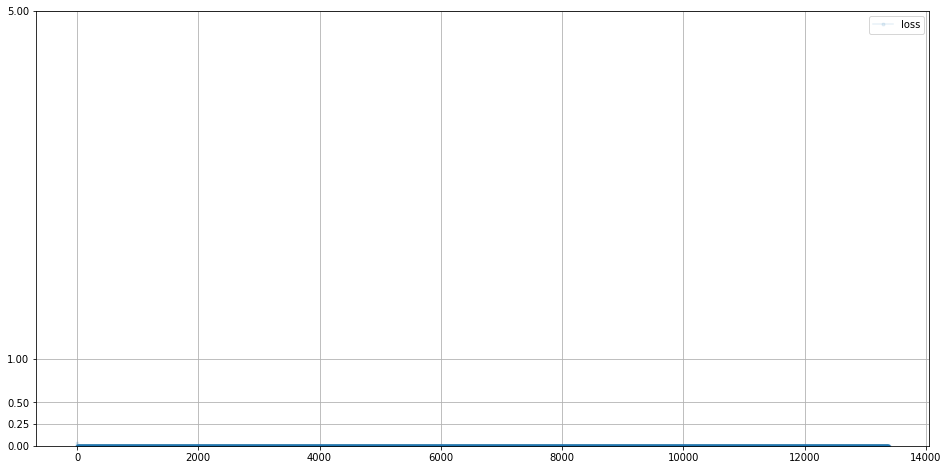

In [16]:
# check Discriminator progress and converge
D.plot_progress()

In [17]:
# Test discriminator by real data 
i = 0
for smiles,label,target in data_loader:
    # real
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    result = D.forward(smiles.to(device).float(), label)
    print('label', label)
    print('result',result)
    
    i += 1
    if (i >= 1):
        break
    pass



label tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]], device='cuda:0')
result tensor([2.6824e-08], device='cuda:0', grad_fn=<SigmoidBackward>)


In [18]:
# Test discriminator by fale data
fake_input = []
fake_label = []
for item in generate_random_seed(batch_size):
    fake_input.append(item[0])
    fake_label.append(item[1])
    
target = torch.FloatTensor(fake_label).view(1,len(fake_label),1).to(device)
fake_input = torch.FloatTensor(fake_input).to(device)
fake_label = torch.FloatTensor(fake_label).to(device)
fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
result = D.forward(fake_input, fake_label)
print('fake_label', fake_label)
print('result', result) 


fake_label tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]], device='cuda:0')
result tensor([2.7305e-08], device='cuda:0', grad_fn=<SigmoidBackward>)


In [19]:
# generator class

class Generator(nn.Module):
    
    def __init__(self, batch_size):
        # initialise parent pytorch class
        super().__init__()
        
        self.batch_size = batch_size 
        self.model = nn.Sequential(
            nn.Linear(G_input_size * 2, 200),
            nn.LeakyReLU(0.02),
            #nn.LayerNorm(200),
            nn.Linear(200, number_of_data),
            nn.Sigmoid()

        )
        
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate_G)
        
        # monitor
        self.counter = 0;
        self.progress = []
        self.stop = False
        
        pass
    
    
    def forward(self, seed_tensor, label_tensor):        
        # combine seed and label
        inputs = torch.cat((seed_tensor, label_tensor))
        outputs = self.model(inputs)
        return torch.argmax(F.softmax(outputs, dim=0))


    def train(self, D, inputs, label_tensor, targets):
        g_output = self.forward(inputs, label_tensor.repeat(G_input_size))

        # get SMILES by g_output
        g_smiles, _, _ = data_dataset[g_output]

        # convert SMILES to tensor
        g_input = torch.FloatTensor(g_smiles).to(device)
        g_input = g_input.reshape(1, g_input.shape[0], g_input.shape[1])

        # convert label_tensor dimension
        g_label = label_tensor.repeat(1, g_input.shape[1], 1)
        
        # pass to discriminator
        d_output = D.forward(g_input, g_label)
        
        # calculate error
        loss = D.loss_function(d_output, targets)
        
        # monitor 
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()


        pass
    

    def get_smiles(self, label):
        label_tensor = torch.zeros((G_input_size))
        for i in range(G_input_size):
            label_tensor[i] = label
    
        fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
        fake_label = torch.FloatTensor(label_tensor).to(device)
        idx = G.forward(fake_input, fake_label).detach().cpu().numpy()
        return x_data['smiles'].iloc[idx]

    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [20]:
# check the generator output is of the right type and shape

G = Generator(1)
G.to(device)

fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
fake_label = torch.FloatTensor(generate_random_value(G_input_size)).to(device)
idx = G.forward(fake_input, fake_label)
print('idx', idx)
data_dataset[idx]

idx tensor(15779, device='cuda:0')


(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],

In [21]:

G.get_smiles(1.0)

'CC(NC(N)=[NH2+])C([O-])=O'

In [ ]:
%%time

# train Discriminator and Generator
D = Discriminator()
D.to(device)
G = Generator(batch_size)
G.to(device)


for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    # train Discriminator and Generator
    for smiles,label,target in data_loader:
        # train discriminator on true
        target = torch.FloatTensor(torch.ones(smiles.shape[0])).to(device)
        label = label.float().to(device)
        label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
        D.train(smiles.to(device).float(), label, target)
        
        # train discriminator on false
        fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
        fake_label = torch.FloatTensor(generate_random_label(1)).to(device)
        idx = G.forward(fake_input, fake_label.repeat(G_input_size)).detach().cpu().numpy()
        g_smiles, _, _ = data_dataset[idx]
        g_input = torch.FloatTensor(g_smiles).to(device)
        g_input = g_input.reshape(1, g_input.shape[0], g_input.shape[1])
        g_label = fake_label.repeat(1, g_input.shape[1], 1)
        target = torch.FloatTensor(torch.zeros(len(fake_label))).to(device)
        D.train(g_input, g_label, target)

        # train generator
        fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
        fake_label = torch.FloatTensor(generate_random_label(1)).to(device)
        target = torch.FloatTensor([0.0]).to(device)
        G.train(D, fake_input, fake_label, target)
        
    pass
pass


epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  5

counter =  460000
counter =  461000
counter =  462000
counter =  463000
counter =  464000
counter =  465000
counter =  466000
counter =  467000
counter =  468000
counter =  469000
counter =  470000
counter =  471000
counter =  472000
counter =  473000
counter =  474000
counter =  475000
counter =  476000
counter =  477000
counter =  478000
counter =  479000
counter =  480000
counter =  481000
counter =  482000
counter =  483000
counter =  484000
counter =  485000
counter =  486000
counter =  487000
counter =  488000
counter =  489000
counter =  490000
counter =  491000
counter =  492000
counter =  493000
counter =  494000
counter =  495000
counter =  496000
counter =  497000
counter =  498000
counter =  499000
counter =  500000
counter =  501000
counter =  502000
counter =  503000
counter =  504000
counter =  505000
counter =  506000
counter =  507000
counter =  508000
counter =  509000
counter =  510000
counter =  511000
counter =  512000
counter =  513000
counter =  514000
counter = 

counter =  914000
counter =  915000
counter =  916000
counter =  917000
counter =  918000
counter =  919000
counter =  920000
counter =  921000
counter =  922000
counter =  923000
counter =  924000
counter =  925000
counter =  926000
counter =  927000
counter =  928000
counter =  929000
counter =  930000
counter =  931000
counter =  932000
counter =  933000
counter =  934000
counter =  935000
counter =  936000
counter =  937000
epoch =  8
counter =  938000
counter =  939000
counter =  940000
counter =  941000
counter =  942000
counter =  943000
counter =  944000
counter =  945000
counter =  946000
counter =  947000
counter =  948000
counter =  949000
counter =  950000
counter =  951000
counter =  952000
counter =  953000
counter =  954000
counter =  955000
counter =  956000
counter =  957000
counter =  958000
counter =  959000
counter =  960000
counter =  961000
counter =  962000
counter =  963000
counter =  964000
counter =  965000
counter =  966000
counter =  967000
counter =  968000

counter =  1348000
counter =  1349000
counter =  1350000
counter =  1351000
counter =  1352000
counter =  1353000
counter =  1354000
counter =  1355000
counter =  1356000
counter =  1357000
counter =  1358000
counter =  1359000
counter =  1360000
counter =  1361000
counter =  1362000
counter =  1363000
counter =  1364000
counter =  1365000
counter =  1366000
counter =  1367000
counter =  1368000
counter =  1369000
counter =  1370000
counter =  1371000
counter =  1372000
counter =  1373000
counter =  1374000
counter =  1375000
counter =  1376000
counter =  1377000
counter =  1378000
counter =  1379000
counter =  1380000
counter =  1381000
counter =  1382000
counter =  1383000
counter =  1384000
counter =  1385000
counter =  1386000
counter =  1387000
counter =  1388000
counter =  1389000
counter =  1390000
counter =  1391000
counter =  1392000
counter =  1393000
counter =  1394000
counter =  1395000
counter =  1396000
counter =  1397000
counter =  1398000
counter =  1399000
counter =  1

counter =  1778000
counter =  1779000
counter =  1780000
counter =  1781000
counter =  1782000
counter =  1783000
counter =  1784000
counter =  1785000
counter =  1786000
counter =  1787000
counter =  1788000
counter =  1789000
counter =  1790000
counter =  1791000
counter =  1792000
counter =  1793000
counter =  1794000
counter =  1795000
counter =  1796000
counter =  1797000
counter =  1798000
counter =  1799000
counter =  1800000
counter =  1801000
counter =  1802000
counter =  1803000
counter =  1804000
counter =  1805000
counter =  1806000
counter =  1807000
counter =  1808000
counter =  1809000
counter =  1810000
counter =  1811000
counter =  1812000
counter =  1813000
counter =  1814000
counter =  1815000
counter =  1816000
counter =  1817000
counter =  1818000
counter =  1819000
counter =  1820000
counter =  1821000
counter =  1822000
counter =  1823000
counter =  1824000
counter =  1825000
counter =  1826000
counter =  1827000
counter =  1828000
counter =  1829000
counter =  1

counter =  2208000
counter =  2209000
counter =  2210000
counter =  2211000
counter =  2212000
counter =  2213000
counter =  2214000
counter =  2215000
counter =  2216000
counter =  2217000
counter =  2218000
counter =  2219000
counter =  2220000
counter =  2221000
counter =  2222000
counter =  2223000
counter =  2224000
counter =  2225000
counter =  2226000
counter =  2227000
counter =  2228000
counter =  2229000
counter =  2230000
counter =  2231000
counter =  2232000
counter =  2233000
counter =  2234000
counter =  2235000
counter =  2236000
counter =  2237000
counter =  2238000
counter =  2239000
counter =  2240000
counter =  2241000
counter =  2242000
counter =  2243000
counter =  2244000
counter =  2245000
counter =  2246000
counter =  2247000
counter =  2248000
counter =  2249000
counter =  2250000
counter =  2251000
counter =  2252000
counter =  2253000
counter =  2254000
counter =  2255000
counter =  2256000
counter =  2257000
counter =  2258000
counter =  2259000
counter =  2

In [ ]:
# check Discriminator progress and converge
D.plot_progress()

In [ ]:
# check Generator progress and converge
G.plot_progress()

In [ ]:
qm9_dataset = pandas.read_csv('dataset/qm9.csv')
accuracy = []
number_of_verify = 1000
for i in range(number_of_verify):
    test_smiles = G.get_smiles(1.0)
    real = qm9_dataset[qm9_dataset['smiles'] == test_smiles ]
    accuracy.append(real.iat[0,1] > baseline)
np.mean(accuracy)

In [27]:
i = 0
for smiles,label,target in data_loader:
    # real
    target = torch.FloatTensor([1.0]).view(1,1,1).repeat(1, smiles.shape[0] ,1).to(device)
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    
    #print(label)
    print(D.forward(smiles.to(device).float(), label))
    
    i += 1
    if (i >= 10):
        break
    pass



tensor([0.9644], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.0548], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.0072], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.7540], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.1657], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.7346], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.7689], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.8237], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.9404], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.9302], device='cuda:0', grad_fn=<SigmoidBackward>)


In [28]:
# test train result by getting a SMILES
fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
fake_label = torch.FloatTensor(generate_random_value(G_input_size)).to(device)
result = G.forward(fake_input, fake_label).detach()
idx = result.cpu().numpy()
print('result', result, 'idx', idx, 'fake_input', fake_input.shape, 'fake_label.shape', fake_label.shape,  'result.shape', result.shape)
print(x_data['smiles'].iloc[idx])

result tensor(40779, device='cuda:0') idx 40779 fake_input torch.Size([100]) fake_label.shape torch.Size([100]) result.shape torch.Size([])
C#CC#CCC(=O)C=O


In [29]:
# Save models
import pickle
from datetime import datetime

now = datetime.now() 
date_time = now.strftime("%Y%m%d%H%M")
G_filename = 'pre_train_model/GAN20G' + date_time + '.sav'
print('save model to file:', G_filename)
pickle.dump(G, open(G_filename, 'wb'))

D_filename = 'pre_train_model/GAN20D' + date_time + '.sav'
print('save model to file:', D_filename)
pickle.dump(D, open(D_filename, 'wb'))


save model to file: pre_train_model/GAN20G202104191538.sav
save model to file: pre_train_model/GAN20D202104191538.sav


In [30]:
qm9_dataset = pandas.read_csv('dataset/qm9.csv')

In [31]:
from sklearn.metrics import *

def classification_metrics(Y_pred, Y_true, Y_auc_true, Y_auc_pred):
    acc = accuracy_score(Y_true, Y_pred)
    auc_ = roc_auc_score(Y_auc_true, Y_auc_pred)
    
    precision = precision_score(Y_true, Y_pred, average='weighted')
    recall = recall_score(Y_true, Y_pred, average='weighted')
    f1score = f1_score(Y_true, Y_pred, average='weighted')
    return acc, auc_, precision, recall, f1score


In [32]:
#calculate mertrics
y_true = []
prodict = []
y_auc_true = []
y_auc_prodict = []
number_of_verify = 1000
for i in range(number_of_verify):
    test_smiles = G.get_smiles(1.0)
    real = qm9_dataset[qm9_dataset['smiles'] == test_smiles ]
    y_true.append(float(real.iat[0,1] > baseline) )
    prodict.append(1.0)
    y_auc_true.append(float(real.iat[0,1] > baseline) )
    y_auc_prodict.append(1.0)

# Fix auc issue
y_auc_true.append(0.0)
y_auc_prodict.append(0.0)
    
acc, auc_, precision, recall, f1score = classification_metrics(y_true, prodict, y_auc_true, y_auc_prodict)
print('acc', acc)
print('auc_', auc_)
print('precision', precision)
print('recall', recall)
print('f1score', f1score)

acc 0.521
auc_ 0.5010416666666666
precision 1.0
recall 0.521
f1score 0.6850756081525313


/home/tony/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# Get model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(D)
print("Total parameters of D", count_parameters(D))

print(G)
print("Total parameters of G", count_parameters(G))

Discriminator(
  (model): Sequential(
    (0): View()
    (1): Linear(in_features=875, out_features=200, bias=True)
    (2): LeakyReLU(negative_slope=0.02)
    (3): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    (4): Linear(in_features=200, out_features=1, bias=True)
    (5): Sigmoid()
  )
  (loss_function): MSELoss()
)
Total parameters of D 175801
Generator(
  (model): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.02)
    (2): Linear(in_features=200, out_features=66943, bias=True)
    (3): Sigmoid()
  )
)
Total parameters of G 13495743
